In [ ]:
import pandas as pd

# Read the time series data into a DataFrame
data = pd.read_csv('/content/drive/MyDrive/PHB009/dataset/model/stl_components.csv', parse_dates=['Date'])

# TREND model

Long Short-Term Memory (LSTM) Networks: LSTM networks, a type of recurrent neural network (RNN), are capable of capturing long-term dependencies and nonlinear relationships in time series data. They can be effective for trend prediction in multivariate time series, especially when there are complex patterns and temporal dependencies.

## Influences in the trend component of the price of electricity

The trend of a time series of energy prices in Spain can be influenced by various factors:

1. **Trend**:
   - **Economic Factors**: Overall economic conditions, such as GDP growth, inflation rates, and interest rates, can affect energy prices and contribute to the underlying trend.
   - **Energy Demand and Supply**: Changes in energy demand and supply, including factors like population growth, industrial activities, technological advancements, and government policies, can influence the long-term trend in energy prices.
   - **Renewable Energy Integration**: The integration of renewable energy sources into the energy mix can impact the long-term trend by reducing dependence on fossil fuels and affecting price dynamics.

Adding INE indicators

In [ ]:
ine = pd.read_csv('/content/drive/MyDrive/PHB009/dataset/model/INE.csv', parse_dates=['Date'])

In [ ]:
# Read the time series data into a DataFrame
combined = pd.read_csv('/content/drive/MyDrive/PHB009/dataset/model/combined_data.csv', parse_dates=['Date'])

# Merge the datasets based on the "Date" column
influences = pd.merge(combined, ine, on='Date', how='inner')

# Assuming 'data' is your DataFrame and 'columns_to_drop' is a list of column names to drop
columns_to_drop = ['BOMBEO', 'BRENT', 'CARBON', 'CICLOCOMBINADO', 'COGENERACION', 'EOLICA', 'HIDRAULICA', 'NUCLEAR', 'SOLAR', 'TTF']  # Replace with your column names
influences.drop(columns=columns_to_drop, inplace=True)
influences.fillna(method='ffill', inplace=True)
influences.fillna(method='bfill', inplace=True)

In [ ]:
# Merge the datasets based on the "Date" column
merged_df = pd.merge(data, influences, on='Date', how='inner')
merged_df.head(5)

,Date,Trend,Seasonal,Residual,Price,Open,High,Low,Close,GasPrice,...,MIBGAS,OMIP,AnualRate,PreviousQuarter,MonthlyRate,AnnualRate,OverTheYear,Poblacion,ProduccionIndustrial,Interest Rate (%)
0,2018-01-01,33.868626,-0.778812,-7.514161,25.575652,28.10,33.00,19.84,28.10,21.81,...,21.81,61.85,2.6,0.4,-1.1,0.6,-1.1,46645070.0,3.3,0.5
1,2018-01-02,36.780803,3.065090,0.549108,40.395000,27.60,55.54,19.10,50.50,22.51,...,22.51,61.85,2.6,0.4,-1.1,0.6,-1.1,46645070.0,3.3,0.5
2,2018-01-03,39.614559,2.086363,3.958244,45.659167,39.63,54.45,28.10,51.01,20.40,...,20.40,61.85,2.6,0.4,-1.1,0.6,-1.1,46645070.0,3.3,0.5
3,2018-01-04,42.383445,-0.592424,3.649813,45.440833,41.69,50.08,39.10,48.11,19.01,...,19.01,61.85,2.6,0.4,-1.1,0.6,-1.1,46645070.0,3.3,0.5
4,2018-01-05,45.089123,0.905734,-1.836107,44.158750,40.00,61.01,13.51,58.05,19.78,...,19.78,61.85,2.6,0.4,-1.1,0.6,-1.1,46645070.0,3.3,0.5


## LSTM Model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Merge the datasets based on the "Date" column
merged_df = pd.merge(data, influences, on='Date', how='inner')

################################################################################
#             CHECKING PREDICTION USING PRICE INSTEAD OF TREND
# merged_df['Trend'] = merged_df['Price']
################################################################################

# Convert the date column to datetime type
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Set 'Date' column as the index
merged_df.set_index('Date', inplace=True)

# Initialize aggregation_functions dictionary
aggregation_functions = {}

for col in merged_df.columns:
    if col == 'Price':
        aggregation_functions[col] = 'mean'
    elif col == 'Open':
        aggregation_functions[col] = 'first'
    elif col == 'High':
        aggregation_functions[col] = 'max'
    elif col == 'Low':
        aggregation_functions[col] = 'min'
    elif col == 'Close':
        aggregation_functions[col] = 'last'
    else:
        aggregation_functions[col] = 'mean'

# Resample and aggregate by 4-week intervals
data_weeks = merged_df.resample('W-Mon', closed='right', label='right').agg(aggregation_functions)

# Recover 'Date' as a column and reset the index
data_weeks.reset_index(inplace=True)

# Assuming 'data' is your DataFrame and 'columns_to_drop' is a list of column names to drop
columns_to_drop =  ['Price','Open', 'High', 'Low', 'Close', 'Seasonal', 'Residual']
data_weeks.drop(columns=columns_to_drop, inplace=True)
data_weeks.fillna(method='ffill', inplace=True)
data_weeks.fillna(method='bfill', inplace=True)

# Select the relevant columns for the LSTM model
columns = data_weeks.columns.tolist()
lstm_data = data_weeks[columns].copy()

# Set the 'Date' column as the index
lstm_data.set_index('Date', inplace=True)

# Extract the column you want to move and remove it from the DataFrame
column_to_move = lstm_data.pop('Trend')

# Insert the column back at the beginning of the DataFrame
lstm_data.insert(0, 'Trend', column_to_move)

# Set the date ranges for train, validation, and test sets
val_start_date = '2022-12-31'
val_end_date = '2022-12-31'
test_start_date = '2022-10-08'
test_end_date = '2023-06-01'

# Divide the data into train and test sets
train_data = lstm_data.loc[lstm_data.index < val_start_date]
valid_data = lstm_data.loc[(lstm_data.index >= val_start_date) & (lstm_data.index <= val_end_date)]
test_data = lstm_data.loc[(lstm_data.index >= test_start_date) & (lstm_data.index <= test_end_date)]

# Normalize the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
################################################################################
#             REMOVING VALIDATION AS IT TOOK CRITICAL DATA FROM THE MODEL
################################################################################
#valid_data_scaled = scaler.transform(valid_data)
test_data_scaled = scaler.transform(test_data)

# Define the number of time steps and features
n_steps = 12  # Number of time steps to consider
n_features = lstm_data.shape[1] - 1  # Number of features (excluding the date column)

# Prepare the data for LSTM training
X_train, y_train = [], []
for i in range(n_steps, len(train_data_scaled)):
    X_train.append(train_data_scaled[i - n_steps:i, 1:])  # Exclude the date and price columns
    y_train.append(train_data_scaled[i, 1])  # Price column
X_train, y_train = np.array(X_train), np.array(y_train)

# Prepare the data for LSTM training
################################################################################
#             REMOVING VALIDATION AS IT TOOK CRITICAL DATA FROM THE MODEL
################################################################################
#
#X_valid, y_valid = [], []
#for i in range(n_steps, len(valid_data_scaled)):
#    X_valid.append(valid_data_scaled[i - n_steps:i, 1:])  # Exclude the date and price columns
#    y_valid.append(valid_data_scaled[i, 1])  # Price column
#X_valid, y_valid = np.array(X_valid), np.array(y_valid)

# Define the function to create the LSTM model
def create_model(units):
    model = Sequential()
    model.add(LSTM(units=units, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Create the KerasRegressor wrapper for GridSearchCV
best_model = create_model(units=100)
best_epochs = 20
best_batch_size = 32

# Train the model and store the history
################################################################################
#             REMOVING VALIDATION AS IT TOOK CRITICAL DATA FROM THE MODEL
################################################################################
#history = best_model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, validation_data=(X_valid, y_valid), verbose=0)
history = best_model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=0)

In [ ]:
'''

################################################################################
#             REMOVING VALIDATION AS IT TOOK CRITICAL DATA FROM THE MODEL
################################################################################

# Make predictions on the validation data
forecast_valid_scaled = best_model.predict(X_valid)

# Reshape forecast_valid_scaled to match the expected shape
n_samples_valid = len(forecast_valid_scaled)
forecast_reshaped_valid = np.full((n_samples_valid, n_features + 1), np.nan)
forecast_reshaped_valid[:, 1] = forecast_valid_scaled.flatten()

# Perform inverse scaling to get the forecasted values in the original scale
forecast_valid = scaler.inverse_transform(forecast_reshaped_valid)[:, 1]

# Calculate the RMSE on the validation data
rmse_valid = np.sqrt(mean_squared_error(y_valid, forecast_valid))

# Print the RMSE
print("Root Mean Squared Error (RMSE) on Validation Data:")
print(rmse_valid)
'''

In [ ]:
test_start_date = '2022-10-08'
test_end_date = '2023-06-01'

# Specify test set
test_data = lstm_data.loc[(lstm_data.index >= test_start_date) & (lstm_data.index <= test_end_date)]

# Normalize the test data
test_data_scaled = scaler.transform(test_data)

# Prepare the data for LSTM testing
X_test, y_test = [], []
for i in range(len(test_data_scaled) - n_steps + 1):
    X_test.append(test_data_scaled[i:i + n_steps, 1:])  # Exclude the date and price columns
    y_test.append(test_data_scaled[i, 1])  # Price column
X_test = np.array(X_test)

# Make predictions using the trained LSTM model
forecast_scaled = best_model.predict(X_test)

# Reshape forecast_scaled to match the expected shape
n_samples = len(forecast_scaled)
forecast_reshaped = np.full((n_samples, n_features + 1), np.nan)
forecast_reshaped[:, 1] = forecast_scaled.flatten()

# Perform inverse scaling and extract the forecasted price
forecast = scaler.inverse_transform(forecast_reshaped)[:, 1]

# Create a DataFrame for the forecasted values
forecast_index = pd.date_range(start=test_start_date, periods=len(forecast), freq='W-Mon')
forecast_index = forecast_index.shift(n_steps, freq='W-Mon')  # Shift the index by n_steps 4-weeks
forecast_data = pd.DataFrame({'Date': forecast_index, 'Forecasted Trend': forecast})

# Calculate the mean squared error (MSE) on the test data
mse_test = mean_squared_error(y_test, forecast)

# Calculate the root mean squared error (RMSE) on the test data
rmse_test = np.sqrt(mse_test)

# Print the RMSE on the test data
print("Root Mean Squared Error (RMSE) on Test Data:")
print(rmse_test)

1/1 [==============================] - 0s 185ms/step
Root Mean Squared Error (RMSE) on Test Data:
69.44476542163683


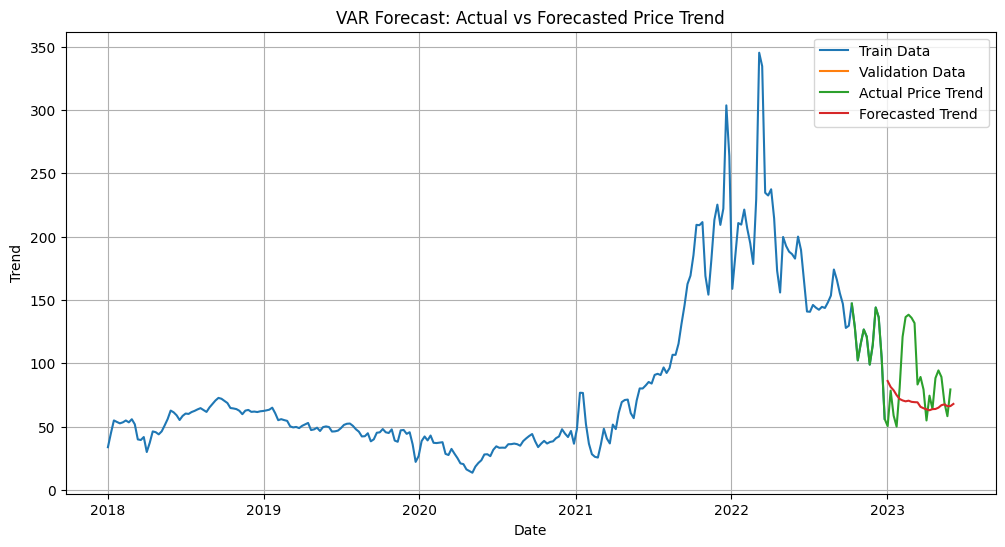

In [ ]:
import matplotlib.pyplot as plt

# Set the 'Date' column as the index
forecast_data.set_index('Date', inplace=True)

# Plot the actual and forecasted prices
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Trend'], label='Train Data')
plt.plot(valid_data.index, valid_data['Trend'], label='Validation Data')
plt.plot(test_data.index, test_data['Trend'], label='Actual Price Trend')
plt.plot(forecast_data.index, forecast_data['Forecasted Trend'], label='Forecasted Trend')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.title('VAR Forecast: Actual vs Forecasted Price Trend')
plt.legend()
plt.grid(True)
plt.show()

# SEASONAL model

## Neural Prophet seasonality calculation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Read the time series data into a DataFrame
combined = pd.read_csv('/content/drive/MyDrive/PHB009/dataset/model/combined_data.csv', parse_dates=['Date'])

In [ ]:
# Read the CSV file
df = pd.read_csv('/content/drive/MyDrive/PHB009/dataset/model/FBNeuralProphet.csv', parse_dates=['ds'])

# Rename the 'ds' column as 'Date'
df.rename(columns={'ds': 'Date'}, inplace=True)

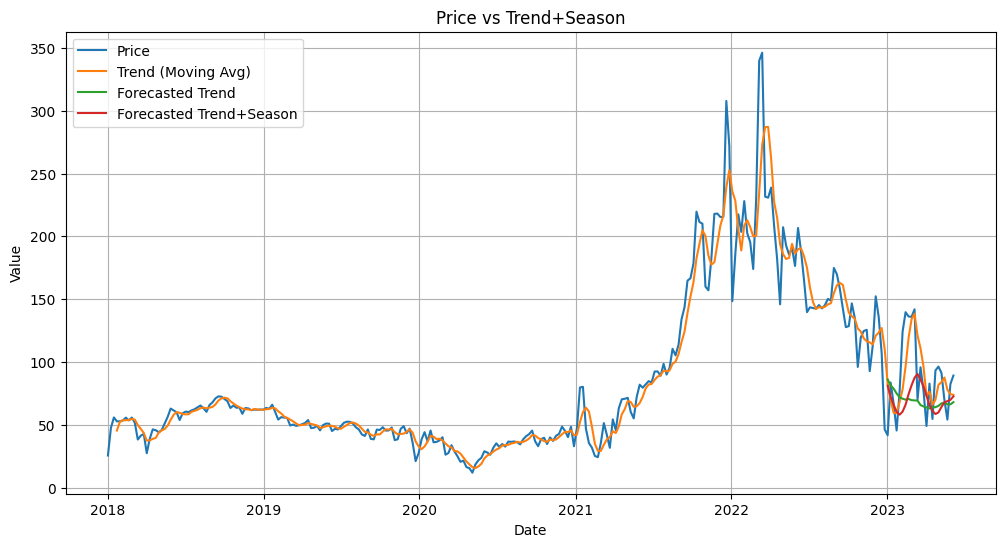

In [ ]:
# Merge DataFrames based on the "Date" column
result = pd.merge(df, combined, on='Date', how='inner')

# Set the 'Date' column as the index
result.set_index('Date', inplace=True)

# Filter the data from 2018-01-01 to 2023-06-01
filtered_data = result.loc['2018-01-01':'2023-06-01', ['Price','trend', 'season_yearly', 'season_weekly']]
filtered_data = filtered_data.rename(columns={'trend': 'Trend', 'season_yearly': 'seasony', 'season_weekly': 'seasonw'})

# Convert the index of filtered_data to the same data type as forecast_data
filtered_data.index = pd.to_datetime(filtered_data.index)

# Resample the data to 4-week frequency
filtered_data = filtered_data.resample('W-Mon').mean()  # You can use other aggregation functions if needed

# Merge the columns of filtered_data and forecast_data
combined_data = filtered_data.merge(forecast_data['Forecasted Trend'], how='outer', left_index=True, right_index=True)

# Add a new column "Trend+Season" to combined_data
combined_data['Trend+Season'] = combined_data['seasony'] + combined_data['seasonw'] + combined_data['Forecasted Trend']

# Calculate a n-day moving average for the 'Value' column
window_size = 4
combined_data['Moving_Average'] = combined_data['Price'].rolling(window=window_size).mean()

# Plot the columns "Price" and "Trend+Season"
plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data['Price'], label='Price')
plt.plot(combined_data.index, combined_data['Moving_Average'], label='Trend (Moving Avg)')
plt.plot(combined_data.index, combined_data['Forecasted Trend'], label='Forecasted Trend')
plt.plot(combined_data.index, combined_data['Trend+Season'], label='Forecasted Trend+Season')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Price vs Trend+Season')
plt.legend()
plt.grid(True)
plt.show()

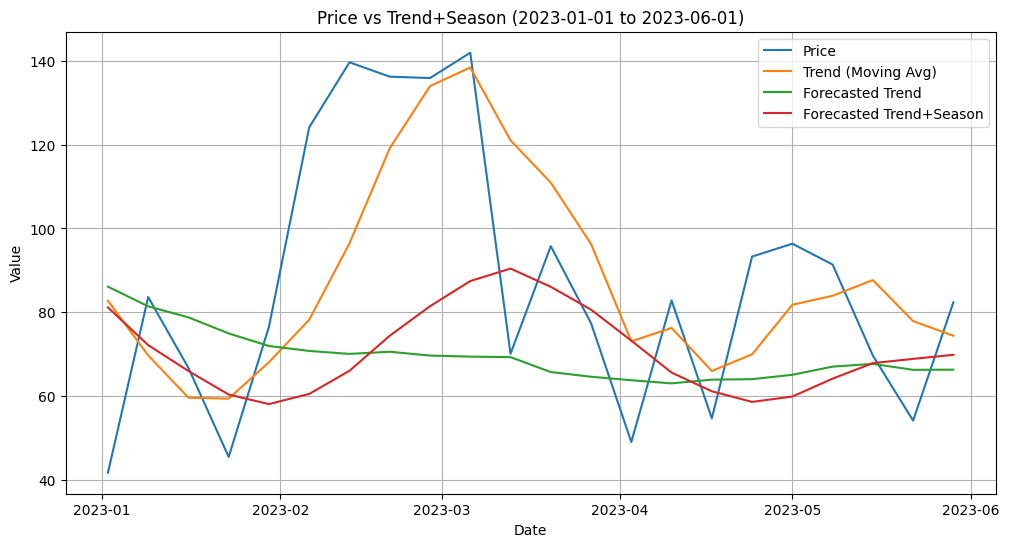

In [ ]:
# Filter the combined dataframe for the desired date range
plot_data = combined_data.loc['2023-01-01':'2023-06-01', ['Price', 'Moving_Average', 'Forecasted Trend', 'Trend+Season']]

# Plot the columns "Price" and "Trend+Season" for the specific date range
plt.figure(figsize=(12, 6))
plt.plot(plot_data.index, plot_data['Price'], label='Price')
plt.plot(plot_data.index, plot_data['Moving_Average'], label='Trend (Moving Avg)')
plt.plot(plot_data.index, plot_data['Forecasted Trend'], label='Forecasted Trend')
plt.plot(plot_data.index, plot_data['Trend+Season'], label='Forecasted Trend+Season')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Price vs Trend+Season (2023-01-01 to 2023-06-01)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculate the mean squared error (MSE) on the test data
mse_test = mean_squared_error(plot_data['Price'], plot_data['Forecasted Trend'])

# Calculate the root mean squared error (RMSE) on the test data
rmse_test = np.sqrt(mse_test)

# Print the RMSE on the test data
print("Root Mean Squared Error (RMSE) on Test Data:")
print(rmse_test)

Root Mean Squared Error (RMSE) on Test Data:
36.47797243962517


In [ ]:
# Calculate the mean squared error (MSE) on the test data
mse_test = mean_squared_error(plot_data['Price'], plot_data['Trend+Season'])

# Calculate the root mean squared error (RMSE) on the test data
rmse_test = np.sqrt(mse_test)

# Print the RMSE on the test data
print("Root Mean Squared Error (RMSE) on Test Data:")
print(rmse_test)

Root Mean Squared Error (RMSE) on Test Data:
34.76280299747643


# RESIDUAL model
Predicting the residuals in a multivariate time series typically involves modeling the unexplained or random component of the data. The choice of the best algorithm for predicting residuals depends on the specific characteristics of the data and the problem requirements.

## Gradient Boosting Machine Model

In [ ]:
# Merge the datasets based on the "Date" column
merged_df = pd.merge(data, influences, on='Date', how='inner')

# 'columns_to_drop' is a list of column names to drop
columns_to_drop = ['Price','Open', 'High', 'Low', 'Close', 'Seasonal', 'Trend']
merged_df.drop(columns=columns_to_drop, inplace=True)
merged_df.fillna(method='ffill', inplace=True)
merged_df.fillna(method='bfill', inplace=True)

# Set the 'Date' column as the index
merged_df.set_index('Date', inplace=True)

# Resample the data to 4-week frequency
merged_df = merged_df.resample('W-Mon').mean()  # You can use other aggregation functions if needed

In [ ]:
merged_df.head(5)

,Residual,GasPrice,Demand,Non-renewable,Renewable,Renewable%,IBEX35,MIBGAS,OMIP,AnualRate,PreviousQuarter,MonthlyRate,AnnualRate,OverTheYear,Poblacion,ProduccionIndustrial,Interest Rate (%)
Date,,,,,,,,,,,,,,,,,
2018-01-01,-7.514161,21.810000,20545.034000,13246.167000,52707.752000,79.916027,10079.099609,21.810000,61.85,2.6,0.4,-1.1,0.6,-1.1,46645070.0,3.3,0.5
2018-01-08,2.546238,20.874286,14063.888857,13379.586714,74235.817571,84.662425,10306.014509,20.874286,61.85,2.6,0.4,-1.1,0.6,-1.1,46645070.0,3.3,0.5
2018-01-15,0.771959,22.250000,11826.107571,4447.265714,73700.817714,94.405175,10449.200195,22.250000,61.85,2.6,0.4,-1.1,0.6,-1.1,46645070.0,3.3,0.5
2018-01-22,-1.082912,19.680000,12913.920429,10913.974714,70080.211286,86.738557,10492.885742,19.680000,61.85,2.6,0.4,-1.1,0.6,-1.1,46645070.0,3.3,0.5
2018-01-29,0.264331,19.035714,8865.175857,5266.271571,68583.602571,92.887765,10587.085798,19.035714,61.85,2.6,0.4,-1.1,0.6,-1.1,46645070.0,3.3,0.5


Validation RMSE: 4.176704525215508
Test RMSE: 6.120688206840306


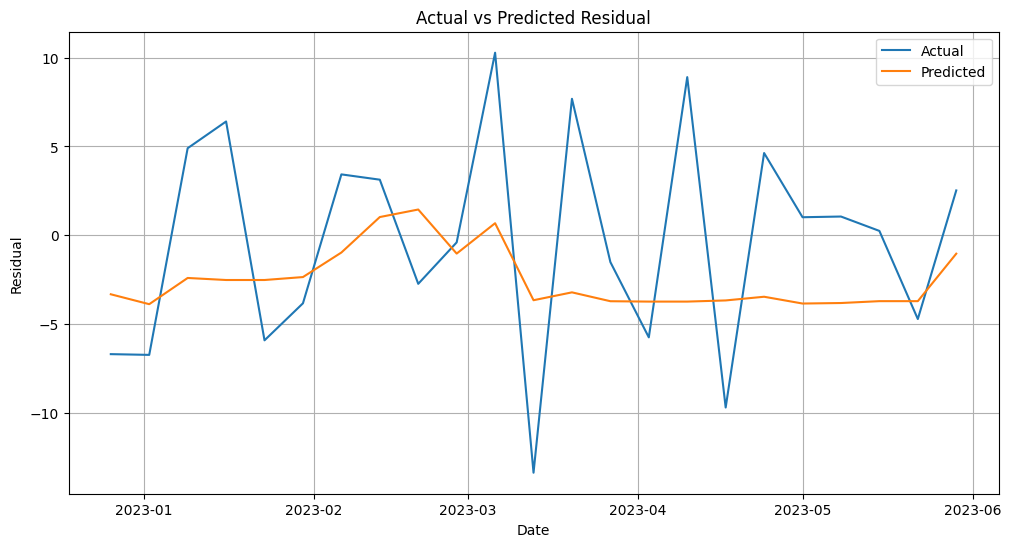

In [ ]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Read the data from the dataframe
data = merged_df.copy()

# Split the data into train, validation, and test sets
train_data = data.loc['2018-01-01':'2022-08-31']
valid_data = data.loc['2022-09-01':'2022-12-24']
test_data = data.loc['2022-12-24':'2023-06-01']

# Separate the features and target columns
X_train = train_data.drop('Residual', axis=1)
y_train = train_data['Residual']
X_valid = valid_data.drop('Residual', axis=1)
y_valid = valid_data['Residual']
X_test = test_data.drop('Residual', axis=1)
y_test = test_data['Residual']

# Initialize and train the GBM regression model
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.01, max_depth=4)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Train the model on the scaled features
model.fit(X_train_scaled, y_train)

# Make predictions on the validation set
y_pred = model.predict(X_valid_scaled)

# Calculate RMSE for the predictions on the validation set
rmse = mean_squared_error(y_valid, y_pred, squared=False)
print("Validation RMSE:", rmse)

# Make predictions on the test set
y_pred_test = model.predict(X_test_scaled)

# Calculate RMSE for the predictions on the test set
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print("Test RMSE:", rmse_test)

# Plot the actual and predicted values for the test set
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label='Actual')
plt.plot(test_data.index, y_pred_test, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Actual vs Predicted Residual')
plt.legend()
plt.grid(True)
plt.show()

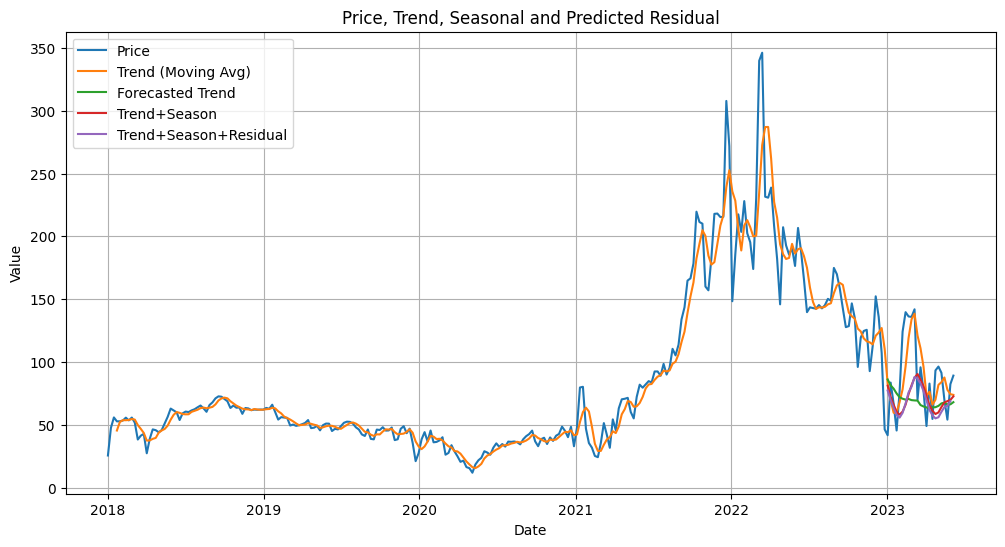

In [ ]:
# Add the predicted values to the combined_data dataframe
combined_data.loc['2022-12-24':'2023-06-01', 'Predicted Residual'] = y_pred_test

# Add a new column "Trend+Season" to combined_data
combined_data['Trend+Season+Residual'] = combined_data['seasony'] + combined_data['seasonw'] + combined_data['Forecasted Trend'] + combined_data['Predicted Residual']

# Plot the columns "Price" and "Trend+Season"
plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data['Price'], label='Price')
plt.plot(combined_data.index, combined_data['Moving_Average'], label='Trend (Moving Avg)')
plt.plot(combined_data.index, combined_data['Forecasted Trend'], label='Forecasted Trend')
plt.plot(combined_data.index, combined_data['Trend+Season'], label='Trend+Season')
plt.plot(combined_data.index, combined_data['Trend+Season+Residual'], label='Trend+Season+Residual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Price, Trend, Seasonal and Predicted Residual')
plt.legend()
plt.grid(True)
plt.show()

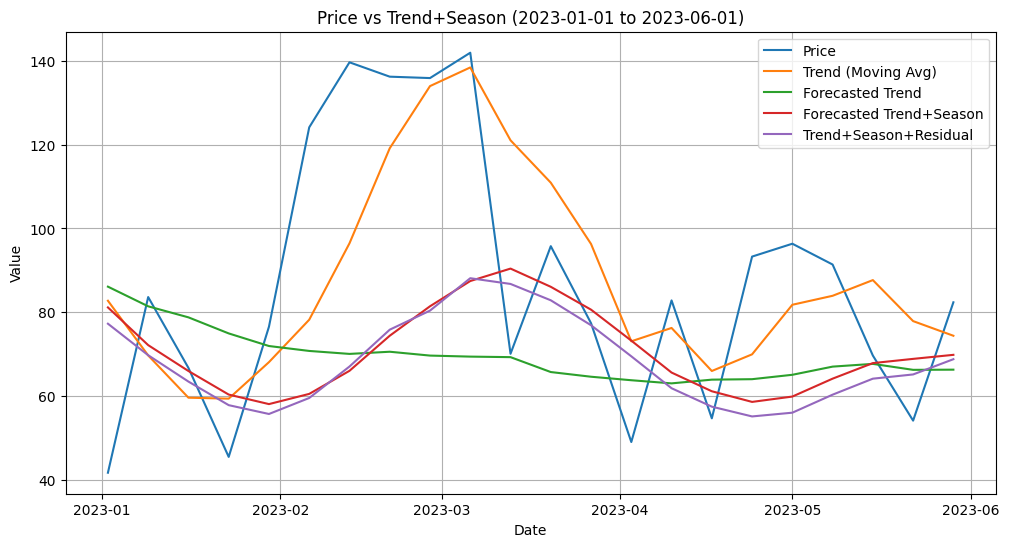

In [ ]:
# Filter the combined dataframe for the desired date range
plot_data = combined_data.loc['2023-01-01':'2023-06-01', ['Price', 'Moving_Average', 'Forecasted Trend', 'Trend+Season', 'Trend+Season+Residual']]

# Plot the columns "Price" and "Trend+Season" for the specific date range
plt.figure(figsize=(12, 6))
plt.plot(plot_data.index, plot_data['Price'], label='Price')
plt.plot(plot_data.index, plot_data['Moving_Average'], label='Trend (Moving Avg)')
plt.plot(plot_data.index, plot_data['Forecasted Trend'], label='Forecasted Trend')
plt.plot(plot_data.index, plot_data['Trend+Season'], label='Forecasted Trend+Season')
plt.plot(plot_data.index, plot_data['Trend+Season+Residual'], label='Trend+Season+Residual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Price vs Trend+Season (2023-01-01 to 2023-06-01)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

def calculate_and_print_rmse(data, column_name):
    # Calculate the mean squared error (MSE) on the test data
    mse_test = mean_squared_error(data['Price'], data[column_name])

    # Calculate the root mean squared error (RMSE) on the test data
    rmse_test = np.sqrt(mse_test)

    # Print the RMSE on the test data
    print(f"Root Mean Squared Error (RMSE) on Test Data ({column_name}):")
    print(rmse_test)

# Call the function for each column
calculate_and_print_rmse(plot_data, 'Forecasted Trend')
calculate_and_print_rmse(plot_data, 'Trend+Season')
calculate_and_print_rmse(plot_data, 'Trend+Season+Residual')

Root Mean Squared Error (RMSE) on Test Data (Forecasted Trend):
36.47797243962517
Root Mean Squared Error (RMSE) on Test Data (Trend+Season):
34.76280299747643
Root Mean Squared Error (RMSE) on Test Data (Trend+Season+Residual):
34.92076480755076


In [ ]:
# Rename the columns
plot_data.rename(columns={'Trend+Season+Residual':'Prediction'}, inplace=True)

# Reset the index and move the Date index back as a column
plot_data.reset_index(drop=False, inplace=True)

# Rename the Date column if needed
plot_data.rename(columns={'index': 'Date'}, inplace=True)

plot_data[['Date','Price','Prediction']].to_csv('/content/drive/MyDrive/PHB009/dataset/model/results/1WSTAResults.csv')
plot_data[['Date','Price','Prediction']]

,Date,Price,Prediction
0,2023-01-02,41.687024,77.258897
1,2023-01-09,83.621190,69.735990
2,2023-01-16,66.705000,63.442555
3,2023-01-23,45.464940,57.817572
4,2023-01-30,76.550119,55.709036
5,2023-02-06,124.137440,59.528131
6,2023-02-13,139.662262,67.037491
7,2023-02-20,136.235000,75.836612
8,2023-02-27,135.901607,80.386827
9,2023-03-06,141.952024,88.121810


## Using Neural Prophet with Residual model

We add the Residual model predictions to the Neural Prophet results and compare



In [ ]:
# Read the time series data into a DataFrame
np_df = pd.read_csv('/content/drive/MyDrive/PHB009/dataset/model/results/1DNeuralProphetResults.csv', parse_dates=['Date'], usecols=range(1,4))

# Set the 'Date' column as the index
np_df.set_index('Date', inplace=True)

np_df = np_df.loc['2023-01-02':'2023-06-01']

# Resample the data to 4-week frequency
np_df = np_df.resample('1W-Mon').mean()  # You can use other aggregation functions if needed

np_df['NPPrediction+GBMResidual'] = np_df['Prediction'] + y_pred_test
np_df

,Price,Prediction,NPPrediction+GBMResidual
Date,,,
2023-01-02,105.573333,101.229752,97.900440
2023-01-09,83.621190,96.093593,92.205963
2023-01-16,66.705000,88.623319,86.212999
2023-01-23,45.464940,84.399195,81.874122
2023-01-30,76.550119,83.139633,80.614560
2023-02-06,124.137440,85.153317,82.793780
2023-02-13,139.662262,90.017896,89.041015
2023-02-20,136.235000,96.550487,97.572924
2023-02-27,135.901607,102.986834,104.433469


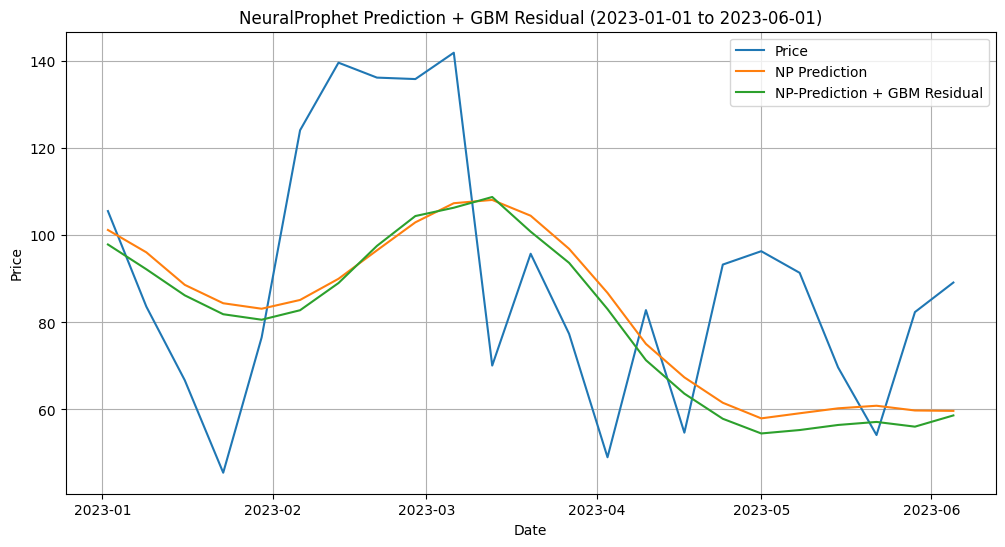

In [ ]:
# Plot the filtered train, test, and forecast
plt.figure(figsize=(12, 6))
plt.plot(np_df.index, np_df['Price'], label='Price')
plt.plot(np_df.index, np_df['Prediction'], label='NP Prediction')
plt.plot(np_df.index, np_df['NPPrediction+GBMResidual'], label='NP-Prediction + GBM Residual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('NeuralProphet Prediction + GBM Residual (2023-01-01 to 2023-06-01)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

def calculate_and_print_rmse(data, column_name):
    # Calculate the mean squared error (MSE) on the test data
    mse_test = mean_squared_error(data['Price'], data[column_name])

    # Calculate the root mean squared error (RMSE) on the test data
    rmse_test = np.sqrt(mse_test)

    # Print the RMSE on the test data
    print(f"Root Mean Squared Error (RMSE) on Test Data ({column_name}):")
    print(rmse_test)

# Call the function for each column
calculate_and_print_rmse(np_df, 'Prediction')
calculate_and_print_rmse(np_df, 'NPPrediction+GBMResidual')

Root Mean Squared Error (RMSE) on Test Data (Prediction):
28.470201384958028
Root Mean Squared Error (RMSE) on Test Data (NPPrediction+GBMResidual):
28.865411918994408


In [ ]:
# Rename the columns
np_df.drop(columns=['Prediction'], inplace=True)
np_df.rename(columns={'NPPrediction+GBMResidual':'Prediction'}, inplace=True)
np_df.reset_index(inplace=True)

np_df[['Date','Price','Prediction']].to_csv('/content/drive/MyDrive/PHB009/dataset/model/results/1WNPGBMResults.csv')